In [113]:
#Import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
!pip install tensorflow_addons
import tensorflow_addons as tfa

In [114]:
num_classes = 10
input_shape = (32,32,3)

(x_train,y_train), (x_test,y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train_shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test_shape: {y_test.shape}")

x_train = x_train[:500]
y_train = y_train[:500]
x_test = x_test[:500]
y_test = y_test[:500]

x_train shape: (50000, 32, 32, 3) - y_train_shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test_shape: (10000, 1)


In [115]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72 #We will resize input images to this size
patch_size = 6 #Size of patches to be extracted from input layers
num_patches = (image_size // patch_size) **2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim*2,
    projection_dim
] #Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] #Size of the dense layers of final classifier

In [116]:
data_augmentation = keras.Sequential(
    [
    layers.Normalization(),
    layers.Resizing(image_size, image_size),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.02),
    layers.RandomZoom(height_factor = 0.2, width_factor = 0.2)
    ],
    name = "data_augmentation"
)
data_augmentation.layers[0].adapt(x_train)

In [117]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation = tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [118]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1,1,1,1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches,[batch_size,-1,patch_dims])
    return patches


In [119]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super(PatchEncoder,self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim = num_patches, output_dim = projection_dim
    )

  def call(self, patch):
    positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


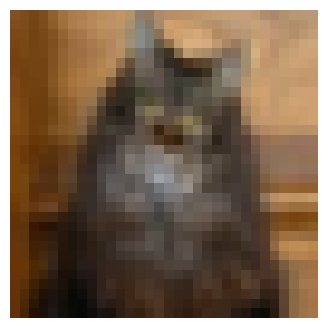

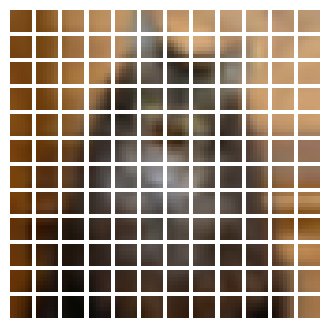

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]),size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i+1)
  patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.axis("off")

In [121]:
def create_vit_classifier():
  inputs = layers.Input(shape = input_shape)
  augmented = data_augmentation(inputs)
  patches = Patches(patch_size)(augmented)
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  #Transformer block
  for _ in range(transformer_layers):
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    attendion_output = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
    )(x1,x1)
    x2 = layers.add([attendion_output, encoded_patches])
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
    encoded_patches = layers.Add()([x3,x2])

  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)
  features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
  logits = layers.Dense(num_classes)(features)

  model = keras.Model(inputs = inputs, outputs = logits)
  return model

In [124]:
def run_program(model):
  optimizer = tfa.optimizers.AdamW(
      learning_rate = learning_rate,
      weight_decay = weight_decay
  )

  model.compile(optimizer = optimizer,
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[
                    keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                    keras.metrics.SparseTopKCategoricalAccuracy(5, name = "top_5_accuracy")
                ])
  checkpoint_filepath = "./tmp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor = "val_accuracy",
      save_best_only=True,
      save_weights_only=True
  )

  history = model.fit(x = x_train, y=y_train, batch_size = batch_size,
                      epochs = num_epochs, validation_split = 0.1, callbacks = [checkpoint_callback])

  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
  print(accuracy, "\n")
  print(top_5_accuracy)

In [125]:
vit_classifier = create_vit_classifier()
history = run_program(vit_classifier)

Epoch 1/40
2/2 [==============================] - 40s 16s/step - loss: 5.9273 - accuracy: 0.1244 - top_5_accuracy: 0.5578 - val_loss: 4.5265 - val_accuracy: 0.2000 - val_top_5_accuracy: 0.7600
Epoch 2/40
2/2 [==============================] - 25s 11s/step - loss: 6.0916 - accuracy: 0.1778 - top_5_accuracy: 0.6778 - val_loss: 3.1648 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.6800
Epoch 3/40
2/2 [==============================] - 23s 10s/step - loss: 3.9334 - accuracy: 0.2178 - top_5_accuracy: 0.6978 - val_loss: 2.6215 - val_accuracy: 0.2800 - val_top_5_accuracy: 0.7200
Epoch 4/40
2/2 [==============================] - 22s 10s/step - loss: 2.9633 - accuracy: 0.2667 - top_5_accuracy: 0.7489 - val_loss: 2.2301 - val_accuracy: 0.2000 - val_top_5_accuracy: 0.7400
Epoch 5/40
2/2 [==============================] - 21s 9s/step - loss: 2.5794 - accuracy: 0.2867 - top_5_accuracy: 0.7667 - val_loss: 2.1945 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.7000
Epoch 6/40
2/2 [====================